1. Cài đặt thư viện

In [3]:
!pip install insightface onnxruntime albumentations scikit-learn joblib matplotlib -q

from google.colab import drive
drive.mount("/content/drive")

import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import albumentations as A
import joblib
import matplotlib.pyplot as plt
import insightface

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.5/439.5 kB 20.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 79.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 78.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 6.5 MB/s eta 0:00:00
Mounted at /content/drive


In [4]:
pip install insightface

2. Load model

In [5]:
import insightface
app = insightface.app.FaceAnalysis(name="buffalo_l")
app.prepare(ctx_id=0,det_size=(160,160))

download_path: /root/.insightface/models/buffalo_l


100%|██████████| 281857/281857 [00:11<00:00, 25497.44KB/s]
/usr/local/lib/python3.12/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:121: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (160, 160)


3. Data Augmentation

In [11]:
augment = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05,
                       rotate_limit=15, border_mode=cv2.BORDER_REFLECT_101, p=0.5),
])

def augment_image(img):
    return augment(image=img)["image"]

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


4. Đọc dataset + trich embedding


In [12]:
data =[]
labels=[]

dataset_path = "/content/drive/MyDrive/dataset"

for filename in os.listdir(dataset_path):
    if filename.endswith(".jpg"):
        # lay nhan tu file
        person_id = int(filename.split("_")[0])
        # doc anh RGB
        img = cv2.imread(os.path.join(dataset_path,filename))
        if img is None :
           continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # data processing : detect face
        faces = app.get(img)
        if len(faces) == 0 :
          continue

        emb= faces[0].embedding
        data.append(emb)
        labels.append(person_id)

        # data augmentation
        img_aug = augment_image(img)
        faces_aug = app.get(img_aug)
        if len(faces_aug) > 0 :
            emb_aug = faces_aug[0].embedding
            data.append(emb_aug)
            labels.append(person_id)

data= np.array(data)
labels= np.array(labels)

print("Tổng số mẫu:", len(labels))
print("Embedding shape:", data.shape)




Tổng số mẫu: 794
Embedding shape: (794, 512)


5. Tran/test split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    data, labels, test_size=0.2, random_state=42, stratify=labels
)

6. Train SVM

In [14]:
svm =SVC(kernel="linear", probability= True)
svm.fit(X_train,y_train)

SVC(kernel='linear', probability=True)

7. Đánh Giá


In [16]:
y_pred = svm.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f" Accuracy trên test: {acc*100:.2f}%")
print("\nBáo cáo chi tiết:\n", classification_report(y_test, y_pred))

 Accuracy trên test: 100.00%

Báo cáo chi tiết:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00        40
           2       1.00      1.00      1.00        39
           3       1.00      1.00      1.00        40
           4       1.00      1.00      1.00        40

    accuracy                           1.00       159
   macro avg       1.00      1.00      1.00       159
weighted avg       1.00      1.00      1.00       159



8. Lưu Model

In [17]:
save_path = "/content/drive/MyDrive/face_buffalo_l_svm.pkl"
joblib.dump(svm,save_path)
print(f"Model svm da luu :{save_path}")

Model svm da luu :/content/drive/MyDrive/face_buffalo_l_svm.pkl


9. Test

Saving WIN_20250901_18_21_09_Pro.jpg to WIN_20250901_18_21_09_Pro.jpg


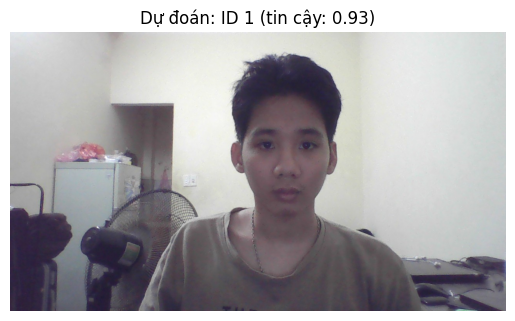

In [19]:
from google.colab import files
uploaded= files.upload()
for fn in uploaded.keys():
    test_img_path= fn

# doc anh rgb
img = cv2.imread(test_img_path)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

# lay embedding tu model cnn
faces= app.get(img)
if len(faces)==0 :
  print("khong tim thay khuon mat")
else:
  emb_test = faces[0].embedding.reshape(1, -1) # chuyen ve mang 2 chieu

  # du doan bang svm da luu
  svm_loaded = joblib.load(save_path)
  pred_label = svm_loaded.predict(emb_test)[0]
  pred_prob =svm_loaded.predict_proba(emb_test).max()

  # hien thi ket qua
  plt.imshow(img)
  plt.axis("off")
  plt.title(f"Dự đoán: ID {pred_label} (tin cậy: {pred_prob:.2f})")
  plt.show()